# Open Quantum Systems: from qubits to quantum biology


# Description

This notebook are the code snippets to go along with the lecture, and to be run on Binder.


In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


Recalling our example of a single two-level system described by the Pauli spin matrices


\begin{align}
\sigma_{x} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix},\quad
\sigma_{y} = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \quad
\sigma_{z} = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix},
\end{align}

In QuTiP we can define this manually, or with predefined operators:


In [2]:
sz = Qobj([[1,0], [0,-1]]) # the sigma-z Pauli operator
sz

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [3]:
sz = sigmaz() # the sigma-z Pauli operator
sz

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

States in diagonal basis can be defined easily

In [16]:
psi = basis(2, 0)    
psi

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

The density matrix of this state is just the outer product

$\rho = |\psi\rangle \langle \psi |$

In [17]:
rho = psi*psi.dag()
rho

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

Another simple example:  equal superposition of both states

$\psi = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$

In [18]:
psi = (basis(2, 0)+basis(2, 1))/sqrt(2)
psi

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]

In [19]:
rho = psi*psi.dag()
rho

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

## Aside: Composite systems

If we have more than one system, like two coupled qubits, or a qubit coupled to cavity (or equivalently, a dimer coupled to a single vibrational mode), we construct operators in a tensor space.

For example, for two qubits, the $\sigma_z$ operator acting on the first qubit $\sigma_z \otimes \mathbf{1}$

In [64]:
sz1 = tensor(sigmaz(), qeye(2))

sz1

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

qeye(2) is the identity matrix, so in the larger space of two systems we are just making a tensor product to get this matrix

Similarly, for terms which are products of two different system operators (like the coupling in a Hamiltonian), we can define,



In [67]:
tensor(sigmax(), sigmax())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [68]:
#equivalent to
sx1 = tensor(sigmax(), qeye(2))

sx2 = tensor(qeye(2),sigmax())

sx1 * sx2


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

## Aside: Superoperators

The Lindblad contains terms like 

$ X \rho_S(t) Y$

For numerical implementation it is convenient to change how we store the density matrix and apply operators by using the superoperator formulation.

Here, we essentially convert the density matrix into a vector in a larger space, writing

$\rho_S(t) = \sum_{n,m} c_n c_m |\psi_n \rangle \langle \psi_m | \rightarrow \sum_{n,m} c_n c_m|\psi_m\rangle\otimes |\psi_n\rangle $



In [14]:
rho = 0.5*(basis(2,0) * basis(2,0).dag()+basis(2,1) * basis(2,1).dag())
print(rho)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]


In [15]:
vec_rho = operator_to_vector(rho)

print(vec_rho)

Quantum object: dims = [[[2], [2]], [1]], shape = (4, 1), type = operator-ket
Qobj data =
[[0.5]
 [0. ]
 [0. ]
 [0.5]]


Then the pre and post multiplation (linear map) becomes a matrix in this larger space. Essentially we are writing
 $  X \rho_S(t) Y \equiv Y^{\dagger}\otimes X \sum_{n,m} c_n c_m|\psi_n\rangle\otimes |\psi_m\rangle  $

In [16]:
X = sigmax()

print(spre(X))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


## Master equation example

First define the Hamiltonian $H_S = \frac{\epsilon}{2}\sigma_z +\frac{\Delta}{2} \sigma_x$ 

and initial condition $\psi(t=0) = |1\rangle$,  $\rho(0) = |1\rangle\langle 1|$


In [27]:


eps = -120
Delta = 87

# Hamiltonian
H = (eps * sigmaz() + Delta * sigmax()) * 3e10 * 2 * pi


# initial state.  
N = 2 # number of states in the Hilbert space
n = 0 # the state that will be occupied (python counts from zero)

psi0 = basis(N, n)     
print(psi0)

print(psi0*psi0.dag())

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]


In [20]:
H.eigenstates()[0] #energies

array([-2.79387047e+13,  2.79387047e+13])

In [22]:
H.eigenstates()[1] #states

array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
       Qobj data =
       [[-0.9512125 ]
        [ 0.30853651]]                                              ,
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
       Qobj data =
       [[0.30853651]
        [0.9512125 ]]                                               ],
      dtype=object)


We can define our Lindblad master equation by just defining the rates and the operator which goes into master equation.

Here we have two operators; one which causes emission, 

<span style="color:green">$$ \sum_{j>l,l}\gamma \left(n+1\right)\left[2 |\psi_l\rangle\langle\psi_j| \rho_S(t) |\psi_j\rangle\langle\psi_l|  -  \{|\psi_j\rangle\langle\psi_j| ,\rho_S\}\right] $$
    
the other absorption
    
<span style="color:red">$$\sum_{j>l,l}\gamma n \left[2 |\psi_j\rangle\langle\psi_l| \rho_S(t) |\psi_l\rangle\langle\psi_j|  -  \{|\psi_l\rangle\langle\psi_l| ,\rho_S\}\right] $$
</span>


In [28]:

gamma = 40 * 3e10 #this should be smaller than our system energies.
n_th = 0.0 #Start with zero temperure for simplicity

all_energy, all_state = H.eigenstates()
Nmax = 2
sz = sigmaz()
collapse_list = []
for j in range(Nmax):

    for k in range(j+1,Nmax):
        #FYI: QuTiPs definition of a Lindblad differs from our derivation by a factor of '2'
        rate = np.absolute(sz.matrix_element(all_state[j].dag(),all_state[k]))**2 * 2 * gamma * (n_th+1)
        if rate > 0.0:
            collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[k].dag()))  #emission
        
        
        rate = np.absolute(sz.matrix_element(all_state[k].dag(),all_state[j]))**2 * 2 *gamma * (n_th)
        if rate > 0.0:
            collapse_list.append((np.sqrt(rate)*all_state[k]*all_state[j].dag())) #absorption
            

Next define the time steps we want to solve the equations for, and run the "mesolve" function

In [29]:
# list of times for which the solver should store the state vector
tlist = linspace(0,0.333e-12,1000)
output = mesolve(H, psi0, tlist, collapse_list)

Lets also run an example where we start in an eigenstate of the Hamiltonian

In [30]:

ee = all_state[1]
output2 = mesolve(H, ee, tlist, collapse_list)


Calculate some expectation values, and compare to analytical result

E:\anaconda3\envs\vanilla2\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


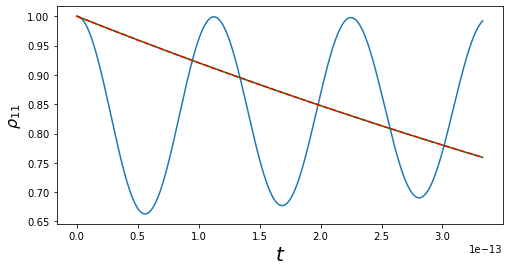

In [31]:
#Since our initial state was the excited state, we can get the probability of being in the excited state
#at time t with:
Pe = expect(output.states, psi0*psi0.dag())
Pe2 = expect(output2.states, ee*ee.dag())

#For the case where we start in eigenstate, we can compare this to our analytical result
PeAna = [np.exp(-2 * sz.matrix_element(all_state[0],all_state[1])**2 * gamma * t) for t in tlist]


fig, axes = plt.subplots(1,1, figsize=(8,4))
axes.plot(tlist, Pe)
axes.plot(tlist, Pe2, color = 'g')
axes.plot(tlist, PeAna, color='r',ls='--')
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"$\rho_{11}$", fontsize=16);

If we assume non-zero temperature, the steady state (the long-time solution) of the master equation predicts a thermal state.

Analytically, setting the LHS of our equations to zero, and solving, gives the disribution:

$$\rho_{ee} = \frac{n}{(1+2n)}$$
$$\rho_{gg} = \frac{1+n}{(1+2n)}$$

Which is equivalent to the thermal distribution:

$$ \rho = e^{H_S/k_B T}/Z $$


Lets check this two ways in QuTiP.  First with steadystate() function, then with the thermal_dm() function

In [32]:
#non zero temperature
n_th = 1.3


collapse_list = []
for j in range(Nmax):

    for k in range(j+1,Nmax):

        rate = np.absolute(sz.matrix_element(all_state[j].dag(),all_state[k]))**2 * 2 * gamma * (n_th+1)
        if rate > 0.0:
            collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[k].dag()))  #emission
        
        
        rate = np.absolute(sz.matrix_element(all_state[k].dag(),all_state[j]))**2 * 2 *gamma * (n_th)
        if rate > 0.0:
            collapse_list.append((np.sqrt(rate)*all_state[k]*all_state[j].dag())) #absorption


In [33]:
            
#Set non-zero temperature and get new collapse_list first
n_th = 1.3

rhoss = steadystate(H,collapse_list)
print(expect(rhoss,all_state[1]*all_state[1].dag()))
print(expect(rhoss,all_state[0]*all_state[0].dag()))

0.36111111111111105
0.6388888888888885


In [34]:
#Compare to analytical prediction
print(n_th / (1+ 2 * n_th))
print((1+n_th) / (1+ 2 * n_th))

0.3611111111111111
0.6388888888888888


In [35]:
#Built in function to calculate thermal state with occupation n_th
print(thermal_dm(2, n_th))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.63888889 0.        ]
 [0.         0.36111111]]


Returning back to our example, can be include more chromophores?  

In the single-excitation limit, we wrote 2-sites as a 2-level system.

For 7-sites we can write a 7-level system with Hamiltonian

$$ H = \sum_{j=1}^7 \epsilon_j |j\rangle\langle j| + \sum_{j,j'} J_{j,j'} \left(|j\rangle \langle j'| + c.c \right)$$

<center>
<img src="fmo.png" height="600" width="600"/>
 </center>

In [36]:

H =  Qobj([[200, -87.7, 5.5, -5.9, 6.7, -13.7, -9.9],
                    [-87.7, 320, 30.8, 8.2, 0.7, 11.8, 4.3],
                    [5.5, 30.8, 0, -53.5, -2.2, -9.6, 6.0],
                    [-5.9, 8.2, -53.5, 110, -70.7, -17.0, -63.3],
                    [6.7, 0.7, -2.2, -70.7, 270, 81.1, -1.3],
                    [-13.7,11.8, -9.6, -17.0 ,81.1, 420, 39.7],
                    [-9.9, 4.3, 6.0, -63.3, -1.3, 39.7, 230]])

print(H)

#Rescale H
H =  3e10 * 2 * pi * H


Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[200.  -87.7   5.5  -5.9   6.7 -13.7  -9.9]
 [-87.7 320.   30.8   8.2   0.7  11.8   4.3]
 [  5.5  30.8   0.  -53.5  -2.2  -9.6   6. ]
 [ -5.9   8.2 -53.5 110.  -70.7 -17.  -63.3]
 [  6.7   0.7  -2.2 -70.7 270.   81.1  -1.3]
 [-13.7  11.8  -9.6 -17.   81.1 420.   39.7]
 [ -9.9   4.3   6.  -63.3  -1.3  39.7 230. ]]


In [37]:
# initial state.  
N = 7 # number of states in the Hilbert space
n = 0 # the state that will be occupied (python counts from zero)

psi0 = basis(N, n)     
print(psi0)

Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


The interaction with the bath becomes a little more complicated.  Now each chromophore is assumed to interact with an independent bath.  Each bath modules the energy of that chromophore via coupling to the operator:

$$H_I = \sum_{m=1}^7 |m\rangle \langle m| \sum_k g_{k,m} (b_{k,m} + b_{k,m}^{\dagger})$$

But, the derivation is done just as before, and we find we can easily adapt our ealier model.

Recall that in the Master equation emission and absorption depend on the environment temperature, and the environment spectral density:
<span style="color:red">
$$J(\omega) = \sum_k g_k^2\delta(\omega-\omega_k)$$
</span>

In many cases we just pretend this is not energy dependent.  However, for FMO, it is know that this function has some structure.  In Ishizaki and Fleming PNAS 2012 they argue that the environment has a decay time of between $50$ fs and $200$ fs. We can capture this with a Drude-Lorentz spectral density:

$$J(\omega) = \frac{2\lambda \gamma \omega}{\pi (\omega^2 + \gamma^2)}$$

$\lambda$ tells us how strong the overall interaction with the environment is

$\gamma$ tell us the bath cut-off, or decay rate, so is inverse of the bath memory time.

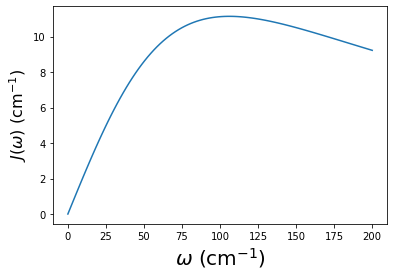

In [38]:

def J0(energy):
    #underdamped brownian oscillator
    lam = 35 * 3e10 * 2 * pi  #35 cm^-1
    gamma = (1/(50e-15))   #1/50 fs
    return 2 * lam * gamma * (energy)/( pi * ((energy**2) + (gamma**2)))
wlist = linspace(0, 200*3e10*2*pi,100)
    
fig, axes = plt.subplots(1,1, figsize=(6,4))

axes.plot(wlist/(3e10*2*pi), [J0(w)/(3e10*2*pi) for w in wlist])
axes.set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=20)
axes.set_ylabel(r"$J(\omega)$ (cm$^{-1}$)", fontsize=16);   

In [45]:


def n_th(energy):
   
    beta=1./Temperature
    
    return 1./(np.exp(energy*beta) - 1.)

def J0(energy):
    #underdamped brownian oscillator
    lam = 35 * 3e10 * 2 * pi
    gamma = (1/(50e-15))
    return 2 * lam * gamma * (energy)/( pi * ((energy**2) + (gamma**2)))

def J02(energy):
    #underdamped brownian oscillator
    lam = 35 * 3e10 * 2 * pi
    gamma = (1/(50e-15))
    return 2 * lam * gamma /(np.pi * ((gamma**2)))



all_energy, all_state = H.eigenstates()

Nmax = 7


Q_list = [basis(Nmax, n)*basis(Nmax, n).dag() for n in range(Nmax)]




def mefunc(Temperature,lam,gamma,dephasing = 0):
    
    collapse_list = []
    for Q in Q_list:
        for j in range(Nmax):

            for k in range(j+1,Nmax):
                Deltajk = abs(all_energy[k] - all_energy[j])
                if abs(Deltajk) > 0 :
                    rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[k]))**2 * 2 * pi * J0(Deltajk) * (n_th(Deltajk)+1)
                    if rate > 0.0:
                        collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[k].dag()))  #emission


                    rate = np.absolute(Q.matrix_element(all_state[k].dag(),all_state[j]))**2 * 2 * pi * J0(Deltajk) * (n_th(Deltajk))
                    if rate > 0.0:
                        collapse_list.append((np.sqrt(rate)*all_state[k]*all_state[j].dag())) #absorption
        if dephasing == 1:
            for j in range(Nmax):

                rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[j]))**2 *  pi * J02(0.) * Temperature
                if rate > 0.0:
                    collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[j].dag()))  #emission
    return collapse_list

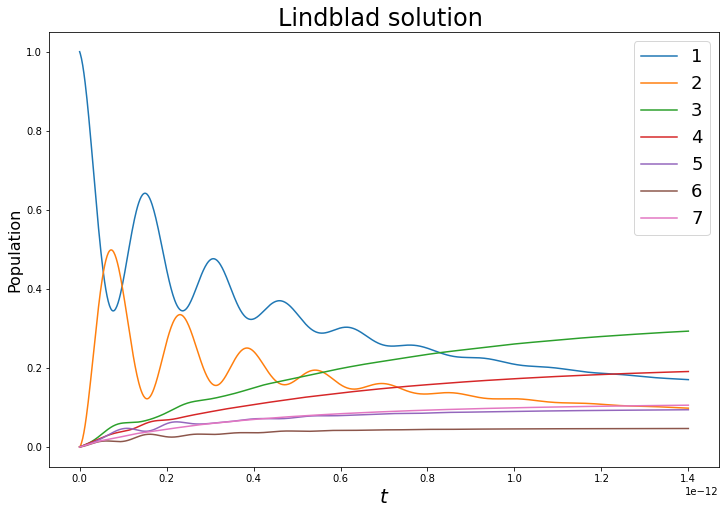

In [59]:
#To be more accurate let us use 300 Kelvin as the temperature
Temperature = 300 * 0.6949 * 3e10 * 2 * pi
lam = 35 * 3e10 * 2 * pi  #35 cm^-1
gamma = (1/(50e-15))   #1/50 fs
tlist = linspace(0,1.4e-12,1000)
collapse_list = mefunc(Temperature,lam,gamma,dephasing=0)
outputFMO = mesolve(H, psi0, tlist, collapse_list)
fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist, expect(outputFMO.states,Q),label=m+1)
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('Lindblad solution ',fontsize=24)
axes.legend(loc=0, fontsize=18)
#fig.savefig("fmosec2.png")

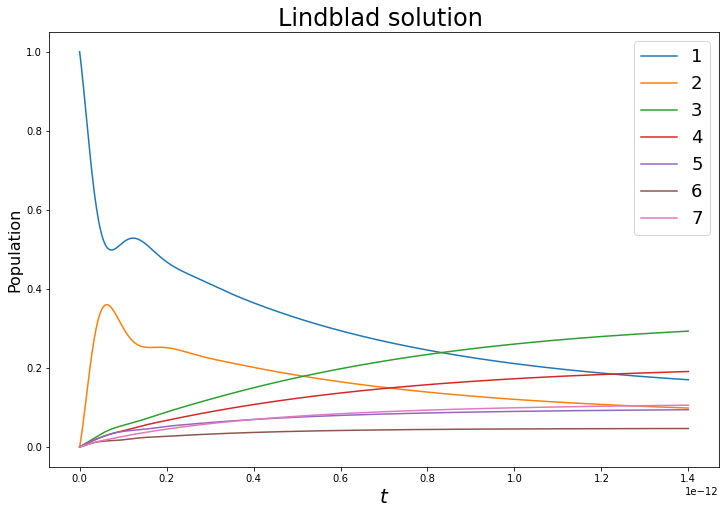

In [60]:
#To be more accurate let us use 300 Kelvin as the temperature
Temperature = 300 * 0.6949 * 3e10 * 2 * pi
lam = 35 * 3e10 * 2 * pi  #35 cm^-1
gamma = (1/(50e-15))   #1/50 fs
tlist = linspace(0,1.4e-12,1000)
collapse_list = mefunc(Temperature,lam,gamma,dephasing=1)
outputFMO = mesolve(H, psi0, tlist, collapse_list)
fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist, expect(outputFMO.states,Q),label=m+1)
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('Lindblad solution ',fontsize=24)
axes.legend(loc=0, fontsize=18)
#fig.savefig("fmosec2.png")

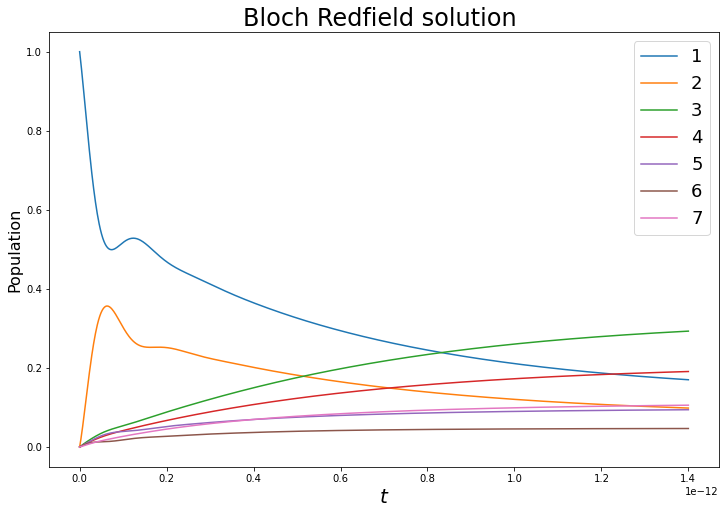

In [61]:
#To be more accurate let us use 300 Kelvin as the temperature
Temperature = 300 * 0.6949 * 3e10 * 2 * pi
lam = 35 * 3e10 * 2 * pi  #35 cm^-1
gamma = (1/(50e-15))   #1/50 fs
tlist = linspace(0,1.4e-12,1000)

beta = 1/Temperature
DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)".format(gamma=gamma, beta = beta, lam = lam)

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)
outputBR  =  brmesolve(H, psi0, tlist, a_ops=[[Q,DL] for Q in Q_list], options = optionsODE)


fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist, expect(outputBR.states,Q),label=m+1)
#for m,Q in enumerate(Q_list):
#    axes.plot(tlist, expect(outputFMO.states,Q),linestyle="--",label=m+1)
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('Bloch Redfield solution ',fontsize=24)
axes.legend(loc=0, fontsize=18)
#fig.savefig("fmoBR.png")

In [62]:
#Calculates  generic non-secular master equation
#This is experimental, and should be used with a grain of salt
#spectral density/w at w=0
def J02(energy):
    #underdamped brownian oscillator
    lam = 35 * 3e10 * 2 * pi
    gamma = (1/(50e-15))
    return 2 * lam * gamma /(np.pi * ((gamma**2)))



def J0(energy):
    #underdamped brownian oscillator
    lam = 35 * 3e10 * 2 * pi
    gamma = (1/(50e-15))
    return 2 * lam * gamma * (energy)/( pi * ((energy**2) + (gamma**2)))


import time
import warnings
import numpy as np
import scipy.sparse as sp
from numpy import matrix
from numpy import linalg
from qutip import spre, spost, sprepost, thermal_dm, mesolve, Odeoptions
from qutip import tensor, identity, destroy, sigmax, sigmaz, basis, qeye, dims
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar
def Lnonsec(Hsys, Q_list, tlist, initial_state, Temperature,
            return_vals, eigen_sparse=False, options=None,progress_bar=None):
    

    if progress_bar is None:
        progress_bar = BaseProgressBar()
    elif progress_bar is True:
        progress_bar = TextProgressBar()
        
    if options is None:
        options = Options()
    output = None
    
   
    
    
    
    dimensions = dims(Q_list[0])
    Nmax = dimensions[1][0]        #hilbert space 
    #Nmax = 2       #hilbert space 
    
    H = Hsys
    L=0
    PsipreEta=0
    PsipreX=0

    all_energy, all_state = H.eigenstates(sparse=eigen_sparse)
    for Q in Q_list:
        Apre = spre(Q)
        Apost = spost(Q)
        for j in range(Nmax):
            for k in range(Nmax):
                A = Q.matrix_element(all_state[j].dag(), all_state[k])
                #A = sh.matrix_element(all_state[j].dag(), all_state[k])
                delE = (all_energy[j] - all_energy[k])
                if np.absolute(A) > 0.0:
                    if abs(delE) > 0.0:
                        #X = (0.5 * np.pi * gamma*(all_energy[j] - all_energy[k])
                        X = (0.5  * np.pi * J0(all_energy[j] - all_energy[k])
                             * (np.cosh((all_energy[j] - all_energy[k]) /
                                (2 * Temperature))
                             / (np.sinh((all_energy[j] - all_energy[k]) /
                                (2 * Temperature)))) * A)
                        #eta = (0.5 * np.pi * gamma *
                        eta = (0.5 *  np.pi *
                               J0(all_energy[j] - all_energy[k]) * A)
                        PsipreX = PsipreX + X * all_state[j]*all_state[k].dag()
                        PsipreEta = PsipreEta + (eta * all_state[j]
                                                 * all_state[k].dag())
                    else:
                        #X =0.5  * np.pi* J0(0.) * A * 2 * Temperature
                        X = 0.5  * np.pi* J02(0.)* A  * 2 * Temperature
                        
                        #X =0.5 * np.pi * gamma * A * 2 * Temperature
                        PsipreX=PsipreX+X*all_state[j]*all_state[k].dag()

        A = Q
        L += ((-spre(A * PsipreX)) + (sprepost(A, PsipreX))
             +(sprepost(PsipreX, A)) + (-spost(PsipreX * A))
             +(spre(A * PsipreEta)) + (sprepost(A, PsipreEta))
             +(-sprepost(PsipreEta, A)) + (-spost(PsipreEta * A)))           

    #Setup the operators and the Hamiltonian and the master equation 
    #and solve for time steps in tlist
    psi0 = ( initial_state)
    output = mesolve(H, psi0, tlist, [L], return_vals, options=options,progress_bar=progress_bar)
    
    return output

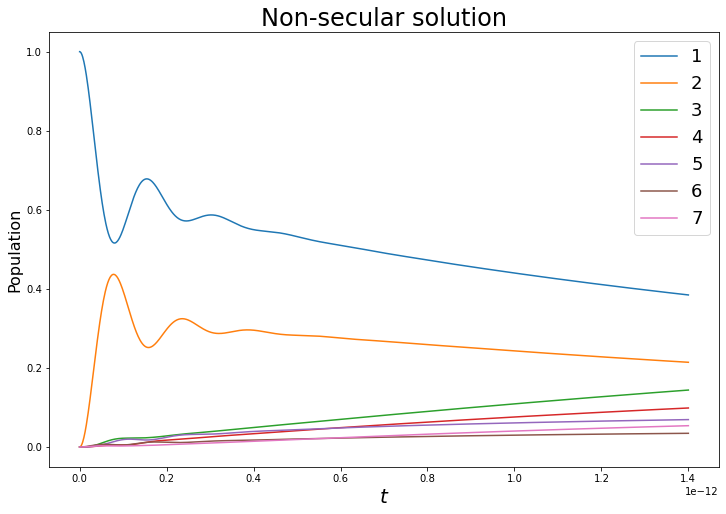

In [63]:
resultMEnonsec = Lnonsec(H, Q_list, tlist, psi0, Temperature, [])
fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist, expect(resultMEnonsec.states,Q),label=m+1)
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('Non-secular solution',fontsize=24)
axes.legend(loc=0, fontsize=18)
#fig.savefig("fmononsec2.png")

Not too dissimilliar time-scales appear...  but is our approach valid here?  If the memory time of the bath is between $50$ and $200$ fs, and the coupling strength is of the order of 35 cm$^{-1}$, both values that may violate the Born-Markov approximations.

<center>
<img src="fmoexperiment.png" height="600" width="600"/>
</center>
